In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import pandas as pd

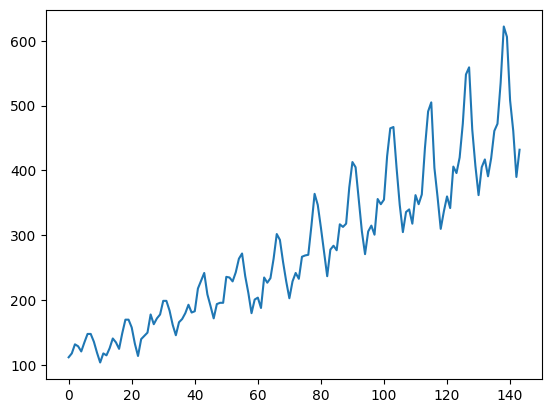

In [ ]:
df = pd.read_csv("airline-passengers.csv")
timeseries = df[["Passengers"]].values.astype("float32")

plt.plot(timeseries)
plt.show()

In [ ]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]


def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + 1 : i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_test.shape, y_test.shape)

torch.Size([44, 4, 1]) torch.Size([44, 4, 1])


In [21]:

 class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


C:\Users\niki\AppData\Local\Temp\ipykernel_15960\4122870348.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
C:\Users\niki\AppData\Local\Temp\ipykernel_15960\4122870348.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 225.5908, test RMSE 424.8245
Epoch 100: train RMSE 176.5636, test RMSE 373.3617
Epoch 200: train RMSE 138.6870, test RMSE 331.7950
Epoch 300: train RMSE 108.0988, test RMSE 295.0030
Epoch 400: train RMSE 84.9670, test RMSE 262.5752
Epoch 500: train RMSE 64.9595, test RMSE 230.8482
Epoch 600: train RMSE 51.2163, test RMSE 204.0833
Epoch 700: train RMSE 41.4123, test RMSE 180.5699
Epoch 800: train RMSE 34.6012, test RMSE 159.9829
Epoch 900: train RMSE 30.6619, test RMSE 142.2271
Epoch 1000: train RMSE 26.6838, test RMSE 127.4924
Epoch 1100: train RMSE 24.5648, test RMSE 115.5242
Epoch 1200: train RMSE 23.2145, test RMSE 105.8542
Epoch 1300: train RMSE 22.3441, test RMSE 99.4397
Epoch 1400: train RMSE 21.3104, test RMSE 92.5951
Epoch 1500: train RMSE 20.7345, test RMSE 89.2336
Epoch 1600: train RMSE 20.5270, test RMSE 85.7038
Epoch 1700: train RMSE 19.8555, test RMSE 82.1856
Epoch 1800: train RMSE 19.5285, test RMSE 80.5832
Epoch 1900: train RMSE 20.2951, test RMSE 79.

C:\Users\niki\AppData\Local\Temp\ipykernel_15960\2540086523.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  train_plot[lookback:train_size] = y_pred # model(X_train)[:, -1, :]
C:\Users\niki\AppData\Local\Temp\ipykernel_15960\2540086523.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


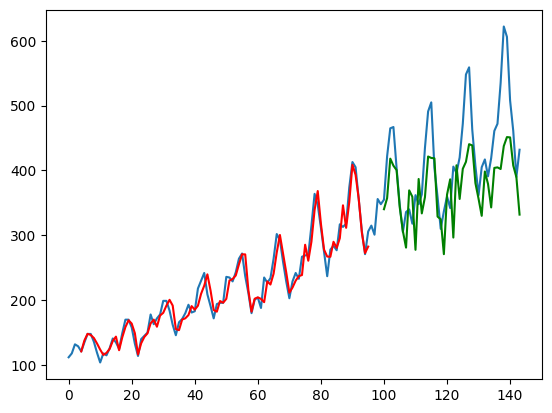

In [23]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = y_pred # model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()